### Build a CNN model to classify fashion items

This notebook steps through how to implement an image recognition model using a convolutional network. It starts with a basic CNN architecture to classify fashion from the Fashion MNIST data set found here: https://github.com/zalandoresearch/fashion-mnist. The data set consists of images (28*28 in size) in 10 different categories. There are 60,000 images for training and 10,000 images for testing. There are optional steps in the notebook to demonstrate use of more advanced network features. 
    
The model is built using Tensorflow and Keras and assumes you are running on a Databricks cluster and machine learning libraries have been pre-installed. 

This notebook is adapted from work published here: 
   (1) https://github.com/amynic/azureml-sdk-fashion and 
   (2) https://github.com/Microsoft/CNTK/tree/v2.0/Tutorials.

### Import core libraries and specify tensorflow and keras

In [1]:
import tensorflow as tf
import os
import time
os.environ["TF_CPP_MIN_LOG_LEVEL"]= "2"
print("tensorflow Version is: " + str(tf.__version__))

import numpy as np
os.environ['KERAS_BACKEND'] = 'tensorflow'

from keras import backend as K
print(os.environ['KERAS_BACKEND'])

tensorflow Version is: 1.14.0
tensorflow


Using TensorFlow backend.


In [2]:
# Import the required Keras functions that will be used to create the CNN
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import utils, losses, optimizers
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt

### Set random seed
This is important for reproducibility of results 

In [3]:
np.random.seed(42)
tf.set_random_seed(42)

### Load the Fashion MNIST data set and visualize an image

The fasion MNIST data set is included with the Keras library so we need to pull it into a training and test datasets. Each image is associated with a label from 1 of 10 classifications: 
  * Label 0: T-shirt/top
  * Label 1: Trouser 
  * Label 2: Pullover 
  * Label 3: Dress 
  * Label 4: Coat 
  * Label 5: Sandal 
  * Label 6: Shirt 
  * Label 7: Sneaker 
  * Label 8: Bag 
  * Label 9: Ankle boot

In [4]:
# Data for training and testing
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

print(x_train.shape, 'train set')
print(x_test.shape, 'test set')

# Define the text labels
fashion_mnist_labels = ["Top",          # index 0
                        "Trouser",      # index 1
                        "Jumper",       # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Trainer",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9



(60000, 28, 28) train set
(10000, 28, 28) test set


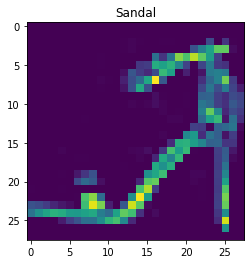

In [5]:
# Visualize an image. To visualize a different image, set the index to any value between 0-59999
img_index=8

# Display an image from the data set
label_index = y_train[img_index]
plt.imshow(x_train[img_index])
plt.title(fashion_mnist_labels[label_index])
 
display()

### Normalize and prepare the data

The data set is loaded into memory and will be normalized so the pixel values in each image range between 0-1 instead of 0-255 pixels. This will help the model converge faster because it is working with smaller numbers.

In this section we also one-hot encode the labels for each image. This is done so the model does not treat the label (fashion category) with an implied numeric ranking. For instance, T-Shirts are labeled '0' and Sneakers are labeled '7'. We don't want the model to interpret these values with any numeric ranking. An array will be created and each image will be represented in the array with a '1' corresponding to its label. For instance, an image with an array that looks like this: array([0,0,0,0,0,0,0,0,0,1]) means the image label corresponds to the 9th index which is 'ankle boots'.

In [6]:
# Set number of categories
num_classes = 10

# Set image input dimensions 
img_rows,img_cols = 28,28

# Reshape the array without changing the data.  
# Parameters = number of elements in the input array, the new shape (28*28) 
x_train = x_train.reshape(60000, img_rows, img_cols, 1)
x_test = x_test.reshape(10000, img_rows, img_cols, 1)

# Type convert and scale the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Save the labels for the confusion matrix later
test_labels = y_test
print(test_labels)

# One-hot encoding of images
# This creates an array equal to the number of labels (fashion categories).  Each image
# is represented in the vector with a 1 corresponding to it's label.  
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)


[9 2 1 ... 8 1 5]


### Define the CNN network architecture
We will use the sequential API and compile the model with a common algorithm and loss metric.

After running through the experiment, consider coming back to this section and changing some of the parameters, re-run the code, and see how the model and accuracy change.

In [7]:
#First, set some parameters

num_classes = 10

# Sample size that will be processed independently, in parallel
batch_size = 256

# Define the CNN model as a sequential model. 
# Every layer passes data forward to the next layer in the network. 
model = Sequential()

# First convolutional layer uses the kernels/filters to extract features to pass to the next layer.
model.add(Conv2D(64, kernel_size=(3,3), activation = 'relu', input_shape=(28,28,1)))

# Pooling layer reduces dimensionality, helps to avoid overfitting
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))

#model.add(Dropout(0.5))

# Add a final, fully connected layer. Image will be classified into one of the 10 fashion classes.  
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=losses.categorical_crossentropy,
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

# Verify model architecture is as expected
model.summary()


W1008 23:59:40.453801 140414725564160 deprecation_wrapper.py:119] From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1008 23:59:40.455752 140414725564160 deprecation_wrapper.py:119] From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1008 23:59:40.458469 140414725564160 deprecation_wrapper.py:119] From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1008 23:59:40.473577 140414725564160 deprecation_wrapper.py:119] From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               204928    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total para

### Display the model structure

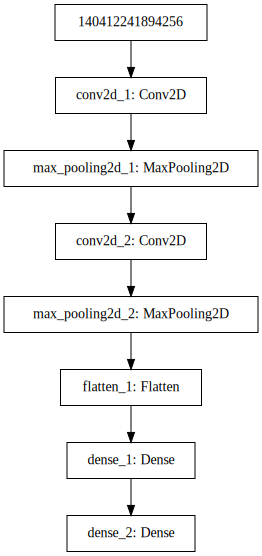

In [8]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Train the model
To train the model, use the fit() method in Keras. This code compiles the CNN model, assigns a common optimizer and loss function and identifies the output metrics to be shown.   
A timer is started to show how long the model takes to run. The test data set is passed in as the validation set so we can see how the accuracy differs between the training set and the validation set.

In [9]:
# Train the model and return loss and accuracy for each epoch

# The number of training passes
epochs = 6

# Batch size is the sample size that will be processed independently, in parallel
batch_size = 256

start = time.time()
hist = model.fit(x_train, y_train, 
                  batch_size=batch_size, 
                  epochs=epochs, verbose=1)
end = time.time()

W1008 23:59:45.512089 140414725564160 deprecation.py:323] From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1008 23:59:45.579685 140414725564160 deprecation_wrapper.py:119] From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/6
60000/60000 [==============================] - 6s 97us/step - loss: 0.6156 - acc: 0.7776
Epoch 2/6
60000/60000 [==============================] - 4s 64us/step - loss: 0.3788 - acc: 0.8646
Epoch 3/6
60000/60000 [==============================] - 4s 64us/step - loss: 0.3238 - acc: 0.8824
Epoch 4/6
60000/60000 [==============================] - 4s 64us/step - loss: 0.2971 - acc: 0.8927
Epoch 5/6
60000/60000 [==============================] - 4s 64us/step - loss: 0.2744 - acc: 0.8998
Epoch 6/6
60000/60000 [==============================] - 4s 64us/step - loss: 0.2505 - acc: 0.9084


In [10]:
# Print how long it took to train the  model
print('Time to train model (sec): ', (end-start))

Time to train model (sec):  25.454025506973267


### Score the model

In [11]:
# Evaluate the model on the test data
score = model.evaluate(x_test, y_test, verbose=0)
print('Test Loss: ', score[0])
print('Test Accuracy: ', score[1])

Test Loss:  0.2824387917637825
Test Accuracy:  0.9012


### Plot model evaluation metrics

Text(0.5, 1.0, 'Training accuracy')

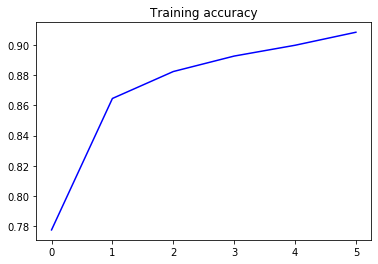

In [12]:
# Plot model accuracy across the epochs 

accuracy = hist.history['acc']

epochs = range(len(accuracy))

fig = plt.figure()
plt.plot(epochs, accuracy, 'b-')
plt.title('Training accuracy')

#display(fig)

Text(0.5, 1.0, 'Training loss')

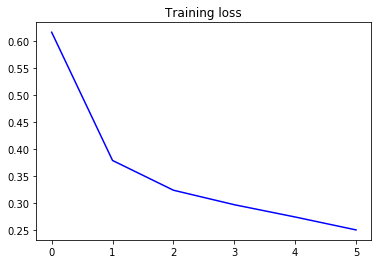

In [13]:
# Plot model loss across the epochs

loss = hist.history['loss']

fig = plt.figure()
plt.plot(epochs, loss, 'b-')
plt.title('Training loss')

#display(fig)

### Predict labels for 15 images from test set

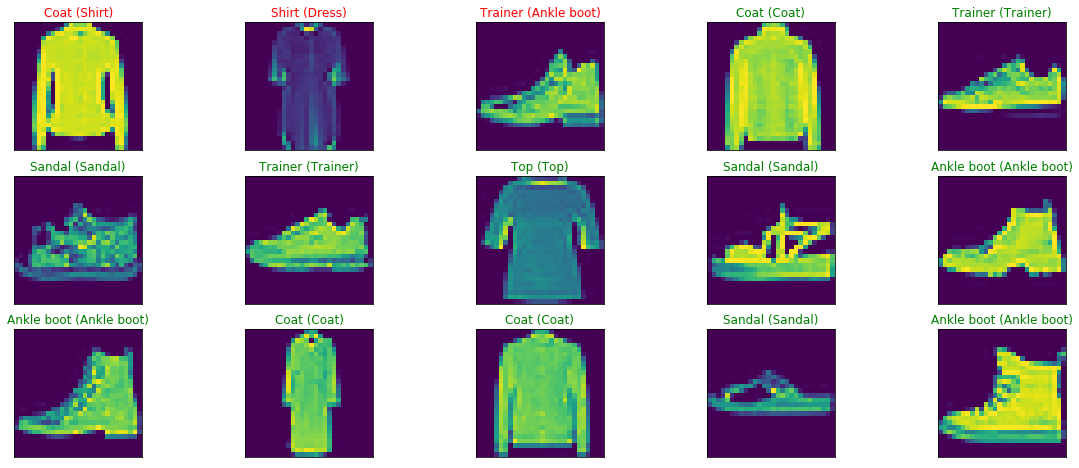

In [14]:
# Run this code to see if the labels for each of 15 images was predicted correctly
predictions = model.predict(x_test)

# Plot a random sample of 15 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = np.argmax(predictions[index])
    true_index = np.argmax(y_test[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(fashion_mnist_labels[predict_index], 
                                  fashion_mnist_labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))
# Visualize in databricks
display()

### Create and plot a confusion matrix

Confusion matrix will show how the predicted labels performed compared to the true labels.

In [15]:
# Import the libraries needed to create the confusion matrix

from sklearn.metrics import confusion_matrix
import itertools

In [16]:
# The predictions are represented as explcit probabilities. For the confusion
# matrix, present them as whole numbers
rounded_predictions = model.predict_classes(x_test)

#print(rounded_predictions)
#print(test_labels)

# Test labels were created in the data pre-processing step 
cm = confusion_matrix(test_labels, rounded_predictions)

Confusion matrix, without normalization


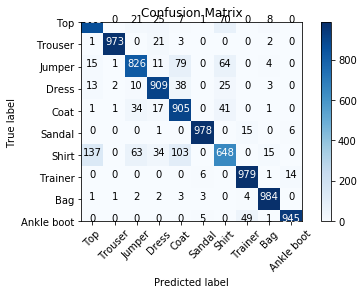

In [17]:
# Confusion matrix code borrowed from here: 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix( cm, classes,
                           normalize=False,
                           title='Confusion matrix',
                           cmap=plt.cm.Blues):
  
  # This function prints and plots the confusion matrix
 
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    # If normalize, plot the raw numbers, otherwise plot the rounded numbers 
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print("Confusion matrix, without normalization")
   
    # Text prints out in white the number of true predictions and
    # black for the number of false predictions  
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i,j],
        horizontalalignment="center",
        color="white" if cm[i,j] > thresh else "black")
             
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')           
      
 
cm_plot_labels = fashion_mnist_labels
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')
display()                           

### Show the impact of changing the activation function

To easily see the impact of changing the activation function, a python function is defined below to construct, compile, train, and score a model.

In [18]:
def runCNN(activation, verbose):

  img_rows, img_cols = 28, 28
  input_shape = (img_rows, img_cols, 1)
  epochs = 1

  # Build the CNN
  model = Sequential()
  
  # Convolution Layer
  model.add(Conv2D(64, kernel_size=(3, 3),
                 activation=activation,
                 input_shape = (28,28,1))) 
  
  # Pooling with stride (2, 2)
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(64, kernel_size=(3,3), activation = 'relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # Flatten layer
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))

   # Randomly delete 50% of neurons to avoid overfitting  
  model.add(Dropout(0.5))
  
   # Apply softmax
  model.add(Dense(num_classes, activation='softmax'))
 
  # Loss function (crossentropy) and Optimizer (Adam)
  model.compile(loss = losses.categorical_crossentropy,
              optimizer = optimizers.Adam(),
              metrics=['accuracy'])
 
  # Train model
  model.fit(x_train, y_train, 
                batch_size=batch_size, 
                epochs=epochs, verbose=0)

  # Evaluate model
  score = model.evaluate(x_test, y_test, verbose=0)
  
  # Return
  return score

In [19]:
# Sigmoid activation  

score_sigmoid = runCNN('sigmoid', 0)
print('Sigmoid, Test loss:', score_sigmoid[0])
print('Sigmoid, Test accuracy:', score_sigmoid[1])


W1008 17:45:05.537034 140635562592000 deprecation.py:506] From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Sigmoid, Test loss: 0.8070080183029175
Sigmoid, Test accuracy: 0.7058


In [20]:
# Tanh activation

score_tanh = runCNN('tanh', 0)
print('tanh, Test loss:', score_tanh[0])
print('tanh, Test accuracy:', score_tanh[1])


tanh, Test loss: 0.4359237837791443
tanh, Test accuracy: 0.8421


In [21]:
# Relu activation

score_sigmoid = runCNN('relu', 0)
print('ReLu, Test loss:', score_sigmoid[0])
print('ReLu, Test accuracy:', score_sigmoid[1])


ReLu, Test loss: 0.45688082971572874
ReLu, Test accuracy: 0.833
